In [44]:
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from pathlib import Path
from monai.transforms import Spacing
import re
import os
from tqdm import tqdm
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance
#from monai.networks.utils import to_onehot

In [46]:
#make list of data dictionaries
train_images_path = Path('../TBI/GT_filtered+raw/') #raw path images
train_images_paths = list(train_images_path.glob('*.tif'))#get images
train_images = sorted([x.as_posix() for x in train_images_paths])#sort
train_labels_path = Path('../TBI/GT_filtered+raw/')#labels path
train_labels = list(train_labels_path.glob('*sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)

In [48]:
print(len(data_dicts))

42


In [50]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:15]
print(len(train))
#log_param('train_set',' '.join(train))
val = mouse_ids_present[15:-6]
print(len(val))
#log_param('val_set',' '.join(val))
test = mouse_ids_present[-6:]

15
4


In [51]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if j.name in k["image"]:
                    test_files.append(k)

In [53]:
train_file = [x['label'] for x in train_files]
#print(len(train_file))
#print(train_file)
val_file = [x['label'] for x in val_files]
#print(len(val_file))
#print(val_file)
test_file = [x['label'] for x in test_files]
print(len(test_file))
print(test_file)

9
['../TBI/GT_filtered+raw/XYZres013_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres95_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres032_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres025_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres114_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres008_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres115_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres204_0001_Simple Segmentation_sub1.tiff', '../TBI/GT_filtered+raw/XYZres214_0001_Simple Segmentation_sub1.tiff']


In [ ]:
test_hausdorf=[]
test_surf_dst=[]
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth==2]=0
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x))):
        pred = io.imread(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x)))
    else:
        pred = io.imread(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','james_preds',x)))
        pred = np.expand_dims(pred,0)
    pred = np.expand_dims(pred,0)
    train_hausdorf.append(compute_hausdorff_distance(truth,pred,percentile=95))
    train_surf_dst.append(compute_average_surface_distance(truth,pred))
truth.shape

 22%|██▏       | 2/9 [00:53<03:04, 26.30s/it]

In [8]:
truth.shape

(1, 1, 507, 507, 252)

In [9]:
pred.shape

(1, 1, 507, 507, 252)

In [10]:
print(train_hausdorf)

[tensor([[7.5498]], dtype=torch.float64), tensor([[15.5563]], dtype=torch.float64), tensor([[24.2848]], dtype=torch.float64), tensor([[48.0937]], dtype=torch.float64), tensor([[4.5826]], dtype=torch.float64), tensor([[6.1644]], dtype=torch.float64), tensor([[3.1623]], dtype=torch.float64), tensor([[2.4495]], dtype=torch.float64), tensor([[2.2361]], dtype=torch.float64), tensor([[2.2361]], dtype=torch.float64), tensor([[20.8806]], dtype=torch.float64), tensor([[13.]], dtype=torch.float64), tensor([[6.]], dtype=torch.float64), tensor([[4.5826]], dtype=torch.float64), tensor([[3.3166]], dtype=torch.float64), tensor([[17.2916]], dtype=torch.float64), tensor([[2.8284]], dtype=torch.float64), tensor([[23.3538]], dtype=torch.float64), tensor([[7.4833]], dtype=torch.float64), tensor([[3.1623]], dtype=torch.float64), tensor([[3.]], dtype=torch.float64), tensor([[3.7417]], dtype=torch.float64), tensor([[4.1231]], dtype=torch.float64), tensor([[3.3166]], dtype=torch.float64), tensor([[4.6904]], d

In [11]:
train_surf_dst

[tensor([[1.9305]], dtype=torch.float64),
 tensor([[1.8373]], dtype=torch.float64),
 tensor([[1.2214]], dtype=torch.float64),
 tensor([[4.9787]], dtype=torch.float64),
 tensor([[1.3866]], dtype=torch.float64),
 tensor([[1.7051]], dtype=torch.float64),
 tensor([[1.1524]], dtype=torch.float64),
 tensor([[0.8662]], dtype=torch.float64),
 tensor([[0.7571]], dtype=torch.float64),
 tensor([[0.8012]], dtype=torch.float64),
 tensor([[4.3569]], dtype=torch.float64),
 tensor([[1.9116]], dtype=torch.float64),
 tensor([[1.7571]], dtype=torch.float64),
 tensor([[1.3309]], dtype=torch.float64),
 tensor([[1.0364]], dtype=torch.float64),
 tensor([[2.5742]], dtype=torch.float64),
 tensor([[0.9966]], dtype=torch.float64),
 tensor([[0.7313]], dtype=torch.float64),
 tensor([[1.3114]], dtype=torch.float64),
 tensor([[1.1463]], dtype=torch.float64),
 tensor([[0.9769]], dtype=torch.float64),
 tensor([[1.4006]], dtype=torch.float64),
 tensor([[1.2805]], dtype=torch.float64),
 tensor([[1.0644]], dtype=torch.fl

In [12]:
val_hausdorf=[]
val_surf_dst=[]
for x in tqdm(val_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth[truth==2]=0
    truth = np.expand_dims(truth,0)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x))):
        pred = io.imread(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x)))
    else:
        pred = io.imread(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','james_preds',x)))
        pred = np.expand_dims(pred,0)
    pred = np.expand_dims(pred,0)
    val_hausdorf.append(compute_hausdorff_distance(truth,pred,percentile=95))
    val_surf_dst.append(compute_average_surface_distance(truth,pred))
truth.shape

100%|██████████| 6/6 [02:32<00:00, 25.43s/it]


(1, 1, 507, 507, 252)

In [13]:
truth.shape

(1, 1, 507, 507, 252)

In [14]:
pred.shape

(1, 1, 507, 507, 252)

In [15]:
x

'../TBI/GT_filtered+raw/XYZres201_Simple Segmentation_sub1.tiff'

In [16]:
truth.shape

(1, 1, 507, 507, 252)

In [17]:
np.mean(np.array([np.array(x[0][0]) for x in val_hausdorf]))

3.8622394151175263

In [18]:
np.std(np.array([np.array(x[0][0]) for x in val_hausdorf]))

1.3843554578380362

In [19]:
np.mean(np.array([np.array(x[0][0]) for x in val_surf_dst]))

1.1986342162312091

In [20]:
np.std(np.array([np.array(x[0][0]) for x in val_surf_dst]))

0.31533004946855353

In [21]:
parameter_file = 'hyperparameter_pickle_files/parameters436.pickle'
experiment = re.sub('.pickle',
                    '',
                    re.sub('hyperparameter_pickle_files/parameters',
                           '',
                           parameter_file
                          )
                   )
directory = re.sub('.pickle',
                   '',
                   re.sub('hyperparameter_pickle_files/parameters',
                          'training_models/',
                           parameter_file
                         )
                  )

In [22]:
_tmp=sorted(list(Path(directory).glob('*.csv')))
_tmp

[PosixPath('training_models/436/metrics_loss.csv'),
 PosixPath('training_models/436/metrics_loss_contd.csv'),
 PosixPath('training_models/436/metrics_loss_contd2.csv'),
 PosixPath('training_models/436/metrics_validation.csv'),
 PosixPath('training_models/436/metrics_validation_round_2.csv'),
 PosixPath('training_models/436/metrics_validation_round_3.csv')]

In [27]:
dice = pd.read_csv(_tmp[3]).append(pd.read_csv(_tmp[4])).append(pd.read_csv(_tmp[5]))['Val_Mean_Dice']

In [28]:
pd.read_csv(_tmp[5])

,Unnamed: 0,Val_Mean_Dice,boundary_detection_dice,boundary_difference_dice
0,0,0.764734,0.243124,0.927574
1,1,0.765234,0.233112,0.944728
2,2,0.763777,0.246058,0.924246
3,3,0.766656,0.225124,0.948180
4,4,0.760488,0.239404,0.936046
...,...,...,...,...
210,210,0.763808,0.239949,0.937239
211,211,0.765220,0.246203,0.932760
212,212,0.766097,0.238264,0.944188
213,213,0.769312,0.241786,0.936474


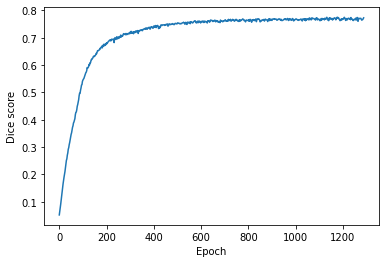

In [29]:
plt.plot(np.arange(0,645*2,2),np.array(dice))
plt.xlabel('Epoch')
plt.ylabel('Dice score')
plt.savefig('436_dice.png')

In [30]:
np.mean(np.array(dice)[-100:])

0.7681033337116241

In [31]:
np.std(np.array(dice)[-100:])

0.003226349278681979

In [32]:
x

'../TBI/GT_filtered+raw/XYZres201_Simple Segmentation_sub1.tiff'

In [33]:
test_hausdorf=[]
test_surf_dst=[]
test_hausdorf_ves=[]
test_surf_dst_ves=[]
test_hausdorf_nrn=[]
test_surf_dst_nrn=[]
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth = np.expand_dims(truth,0)
    truth_shape = np.array(truth.shape)
    truth_shape[1] = len(np.unique(truth))
    truth_one = np.zeros(truth_shape)
    truth_one[:,0,:,:,:] = (truth==0)
    truth_one[:,1,:,:,:] = (truth==1)
    truth_one[:,2,:,:,:] = (truth==2)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','matt_preds',x))):
        pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','matt_preds',x)))
        pred = np.expand_dims(pred,0)
        pred = np.argmax(pred,axis=1)
    else:
        pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','james_preds',x)))
        pred = np.expand_dims(pred,0)
        pred = np.argmax(pred,axis=1)
    pred = np.expand_dims(pred,0)
    pred_shape = np.array(pred.shape)
    pred_shape[1] = len(np.unique(pred))
    pred_one = np.zeros(pred_shape)
    pred_one[:,0,:,:,:] = (pred==0)
    pred_one[:,1,:,:,:] = (pred==1)
    pred_one[:,2,:,:,:] = (pred==2)
    test_hausdorf.append(compute_hausdorff_distance(truth_one,pred_one,percentile=95))
    test_surf_dst.append(compute_average_surface_distance(truth_one,pred_one))
    test_hausdorf_ves.append(compute_hausdorff_distance(truth_one[:,[0,1],:,:,:],pred_one[:,[0,1],:,:,:],percentile=95))
    test_surf_dst_ves.append(compute_average_surface_distance(truth_one[:,[0,1],:,:,:],pred_one[:,[0,1],:,:,:]))
    test_hausdorf_nrn.append(compute_hausdorff_distance(truth_one[:,[0,2],:,:,:],pred_one[:,[0,2],:,:,:],percentile=95))
    test_surf_dst_nrn.append(compute_average_surface_distance(truth_one[:,[0,2],:,:,:],pred_one[:,[0,2],:,:,:]))
truth.shape

100%|██████████| 9/9 [14:30<00:00, 96.74s/it] 


(1, 1, 507, 507, 252)

In [34]:
truth_one[:,[0,1],:,:,:].shape

(1, 2, 507, 507, 252)

In [35]:
print(np.mean(np.array([np.array(x[0]) for x in test_hausdorf])))
print(np.std(np.array([np.array(x[0]) for x in test_hausdorf])))
print(np.mean(np.array([np.array(x[0]) for x in test_surf_dst])))
print(np.std(np.array([np.array(x[0]) for x in test_surf_dst])))

19.078712018144618
16.181006429310933
1.526567827981737
1.0978689874353378


In [36]:
print(np.mean(np.array([np.array(x[0][0]) for x in test_hausdorf_ves])))
print(np.std(np.array([np.array(x[0][0]) for x in test_hausdorf_ves])))
print(np.mean(np.array([np.array(x[0][0]) for x in test_surf_dst_ves])))
print(np.std(np.array([np.array(x[0][0]) for x in test_surf_dst_ves])))

13.729935822684004
11.428034538628665
1.8451601034863085
1.406669786356338


In [37]:
print(np.mean(np.array([np.array(x[0][0]) for x in test_hausdorf_nrn])))
print(np.std(np.array([np.array(x[0][0]) for x in test_hausdorf_nrn])))
print(np.mean(np.array([np.array(x[0][0]) for x in test_surf_dst_nrn])))
print(np.std(np.array([np.array(x[0][0]) for x in test_surf_dst_nrn])))

24.427488213605233
18.325696470706415
1.2079755524771654
0.4784460923389803


In [38]:
test_surf_dst

[tensor([[1.5195, 1.0515]], dtype=torch.float64),
 tensor([[5.0899, 1.4125]], dtype=torch.float64),
 tensor([[0.7621, 1.2950]], dtype=torch.float64),
 tensor([[0.9471, 0.7539]], dtype=torch.float64),
 tensor([[1.9134, 1.0497]], dtype=torch.float64),
 tensor([[0.8407, 0.8652]], dtype=torch.float64),
 tensor([[3.5095, 0.9749]], dtype=torch.float64),
 tensor([[1.1184, 2.4517]], dtype=torch.float64),
 tensor([[0.9057, 1.0174]], dtype=torch.float64)]

In [39]:
test_surf_dst_ves

[tensor([[1.5195]], dtype=torch.float64),
 tensor([[5.0899]], dtype=torch.float64),
 tensor([[0.7621]], dtype=torch.float64),
 tensor([[0.9471]], dtype=torch.float64),
 tensor([[1.9134]], dtype=torch.float64),
 tensor([[0.8407]], dtype=torch.float64),
 tensor([[3.5095]], dtype=torch.float64),
 tensor([[1.1184]], dtype=torch.float64),
 tensor([[0.9057]], dtype=torch.float64)]

In [ ]:
test_hausdorf=[]
test_surf_dst=[]
test_hausdorf_ves=[]
test_surf_dst_ves=[]
test_hausdorf_nrn=[]
test_surf_dst_nrn=[]
for x in tqdm(test_file[:]):
    truth = io.imread(x)
    truth = np.swapaxes(np.swapaxes(truth,0,1),1,3)
    truth = Spacing(pixdim=(1.01, 1.01, 0.3787), mode="nearest")(truth)[0]
    truth = np.expand_dims(truth,0)
    truth_shape = np.array(truth.shape)
    truth_shape[1] = len(np.unique(truth))
    truth_one = np.zeros(truth_shape)
    truth_one[:,0,:,:,:] = (truth==0)
    truth_one[:,1,:,:,:] = (truth==1)
    truth_one[:,2,:,:,:] = (truth==2)
    if os.path.exists(re.sub('_Simple Segmentation_sub1.tiff','_seg.tif',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x))):
        pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        pred = np.expand_dims(pred,0)
        pred = np.argmax(pred,axis=1)
    else:
        pred = np.load(re.sub('_Simple Segmentation_sub1.tiff','_mean.npy',re.sub('../TBI/GT_filtered\+raw','ilastik_preds_raw_images',x)))
        pred = np.expand_dims(pred,0)
        pred = np.argmax(pred,axis=1)
    pred = np.expand_dims(pred,0)
    pred_shape = np.array(pred.shape)
    pred_shape[1] = len(np.unique(pred))
    pred_one = np.zeros(pred_shape)
    pred_one[:,0,:,:,:] = (pred==0)
    pred_one[:,1,:,:,:] = (pred==1)
    pred_one[:,2,:,:,:] = (pred==2)
    test_hausdorf.append(compute_hausdorff_distance(truth_one,pred_one,percentile=95))
    test_surf_dst.append(compute_average_surface_distance(truth_one,pred_one))
    test_hausdorf_ves.append(compute_hausdorff_distance(truth_one[:,[0,1],:,:,:],pred_one[:,[0,1],:,:,:],percentile=95))
    test_surf_dst_ves.append(compute_average_surface_distance(truth_one[:,[0,1],:,:,:],pred_one[:,[0,1],:,:,:]))
    test_hausdorf_nrn.append(compute_hausdorff_distance(truth_one[:,[0,2],:,:,:],pred_one[:,[0,2],:,:,:],percentile=95))
    test_surf_dst_nrn.append(compute_average_surface_distance(truth_one[:,[0,2],:,:,:],pred_one[:,[0,2],:,:,:]))
truth.shape

 56%|█████▌    | 5/9 [07:59<06:17, 94.39s/it] 

In [ ]:
sorted(list(Path('ilastik_preds_raw_images').glob('*.tif')))

In [ ]:
sorted(test_file)